# Load Libaries

In [ ]:
import tensorflow as tf
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import datetime
from sklearn.model_selection import train_test_split

In [ ]:
# Set Parameters
Height = 256
Width = 256
Channels = 3
kernel_size = (3,3)
shape = (Height, Width)
input_shape = (Height, Width, Channels)

# Load BUSI Data

In [ ]:
# Import the Data

imgPath = '/content/drive/MyDrive/Datasets/Segmentation/Original/*.png'
maskPath = '/content/drive/MyDrive/Datasets/Segmentation/Masks/*.png'

img_name = glob.glob(imgPath)
msk_name = glob.glob(maskPath)

img_name.sort()
msk_name.sort()

trainingData = {'image':[], 'mask':[]}

def loadImages(imageData=None, imgList=None, mskList=None, shape=None):
    
    for img in imgList:
        image = cv2.imread(img, 1)
        image = cv2.resize(image, shape)
        imageData['image'].append(image)
        
    for msk in mskList:
        mask = cv2.imread(msk, 1)
        mask = cv2.resize(mask, shape)
        imageData['mask'].append(mask)
        
    return imageData


trainingData = loadImages(trainingData, img_name, msk_name, shape)


images = np.array(trainingData['image'])
masks = np.array(trainingData['mask'])

X = images / 255.0
y = masks / 255.0

In [ ]:
print("Shape of image data",np.shape(X))
print("Shape of mask data",np.shape(y))

Shape of image data (780, 256, 256, 3)
Shape of mask data (780, 256, 256, 3)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
print("Shape of training data",np.shape(X_train))
print("Shape of test data",np.shape(X_test))

print("Shape of training masks",np.shape(y_train))
print("Shape of test masks",np.shape(y_test))

Shape of training data (624, 256, 256, 3)
Shape of test data (156, 256, 256, 3)
Shape of training masks (624, 256, 256, 3)
Shape of test masks (156, 256, 256, 3)


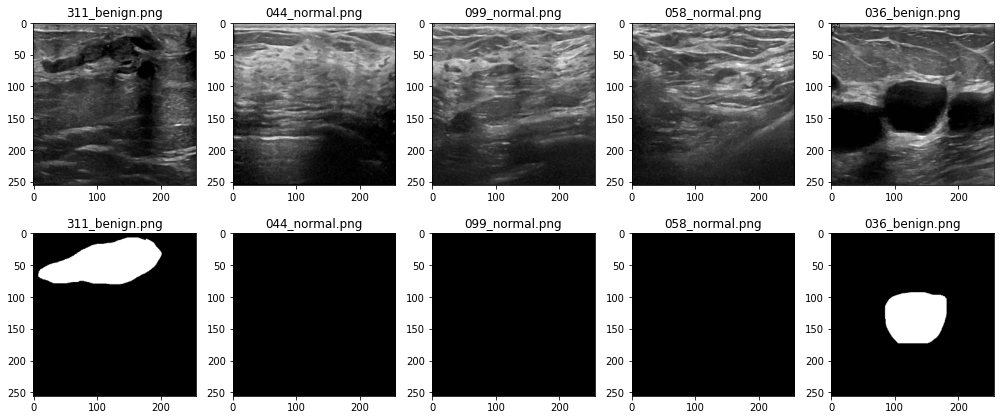

In [ ]:
import random
import os
# Number of random images to display
num_random = 5


img_name = list(map(lambda x: x.split("/")[-1], img_name))
msk_name = list(map(lambda x: x.split("/")[-1], msk_name))

# Get random indices
random_indices = random.sample(range(len(images)), num_random)

plt.figure(figsize = (14,6))
for i, index in enumerate(random_indices):
    plt.subplot(2, num_random, i+1)
    plt.imshow(np.squeeze(images[index]), cmap = "gray")
    plt.title(img_name[index])
    plt.subplot(2, num_random, num_random+i+1)
    plt.imshow(np.squeeze(masks[index]), cmap = "gray")
    plt.title(msk_name[index])
plt.tight_layout()
plt.savefig('image.png', dpi=300)
plt.show()

# Network

## EfficientU-Net Architecture

In [ ]:
def conv_block(inputs, filters):
    x = inputs

    x = tf.keras.layers.Conv2D(filters, (3, 3), padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(filters, (3, 3), padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x

### Encoder

In [ ]:
# Use VGG19 as encoder
def encoder(inputs):
    skip_connections = []

    model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_tensor=inputs)
    names = ["block1_conv2", "block2_conv2", "block3_conv4", "block4_conv4"]
    for name in names:
        skip_connections.append(model.get_layer(name).output)

    output = model.get_layer("block5_conv4").output
    return output, skip_connections

In [ ]:
# Use EfficientNetB0 as encoder
def encoder(inputs):
    skip_connections = []

    model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_tensor=inputs)
    names = ["input_3", "block2a_expand_activation", "block3a_expand_activation", "block4a_expand_activation"]
    for name in names:
        skip_connections.append(model.get_layer(name).output)

    output = model.get_layer("block5a_expand_activation").output
    return output, skip_connections

In [ ]:
# Use EfficientNetB7 as encoder
def encoder(inputs):
    skip_connections = []

    model = tf.keras.applications.EfficientNetB7(include_top=False, weights='imagenet', input_tensor=inputs)
    names = ["input_4", "block2a_expand_activation", "block3a_expand_activation", "block4a_expand_activation"]
    for name in names:
        skip_connections.append(model.get_layer(name).output)

    output = model.get_layer("block5a_expand_activation").output
    return output, skip_connections

In [ ]:
# Use ResNet101v2 as encoder
from keras.applications.resnet_v2 import ResNet101V2
inputs = tf.keras.layers.Input(input_shape)
model = ResNet101V2(include_top=False, weights='imagenet', input_tensor=inputs)

### Decoder

In [ ]:
def decoder(inputs, skip_connections):
    num_filters = [256, 128, 64, 32]
    skip_connections.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = tf.keras.layers.UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = tf.keras.layers.Concatenate()([x, skip_connections[i]])
        x = conv_block(x, f)

    return x

### AC Block

In [ ]:
def AC_block(x, filter):
    shape = x.shape

    y1 = tf.keras.layers.AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y1 = tf.keras.layers.Conv2D(filter, 1, padding="same")(y1)
    y1 = tf.keras.layers.BatchNormalization()(y1)
    y1 = tf.keras.layers.Activation("relu")(y1)
    y1 = tf.keras.layers.UpSampling2D((shape[1], shape[2]), interpolation='bilinear')(y1)

    y2 = tf.keras.layers.Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(x)
    y2 = tf.keras.layers.BatchNormalization()(y2)
    y2 = tf.keras.layers.Activation("relu")(y2)

    y3 = tf.keras.layers.Conv2D(filter, 3, dilation_rate=6, padding="same", use_bias=False)(x)
    y3 = tf.keras.layers.BatchNormalization()(y3)
    y3 = tf.keras.layers.Activation("relu")(y3)

    y4 = tf.keras.layers.Conv2D(filter, 3, dilation_rate=12, padding="same", use_bias=False)(x)
    y4 = tf.keras.layers.BatchNormalization()(y4)
    y4 = tf.keras.layers.Activation("relu")(y4)

    y5 = tf.keras.layers.Conv2D(filter, 3, dilation_rate=18, padding="same", use_bias=False)(x)
    y5 = tf.keras.layers.BatchNormalization()(y5)
    y5 = tf.keras.layers.Activation("relu")(y5)

    y = tf.keras.layers.Concatenate()([y1, y2, y3, y4, y5])

    y = tf.keras.layers.Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Activation("relu")(y)

    return y

### Build Model

In [ ]:
def output_block(inputs):
    x = tf.keras.layers.Conv2D(3, (1, 1), padding="same")(inputs)
    x = tf.keras.layers.Activation('sigmoid')(x)
    return x

In [ ]:
def Upsample(tensor, size):
    """Bilinear upsampling"""
    def _upsample(x, size):
        return tf.image.resize(images=x, size=size)
    return tf.keras.layers.Lambda(lambda x: _upsample(x, size), output_shape=size)(tensor)

In [ ]:
def build_model(shape):
    inputs = tf.keras.layers.Input(shape)
    x, skip_1 = encoder(inputs)
    x = AC_block(x, 64)
    x = decoder(x, skip_1)
    outputs = output_block(x)

    model = tf.keras.models.Model(inputs, outputs)
    return model

### Loss Function

In [ ]:
import tensorflow.keras.backend as K

def BCEDiceLoss(y_true, y_pred):
    smooth = 1e-5
    y_pred = tf.sigmoid(y_pred)
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = y_true_f * y_pred_f
    dice = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    dice = 1 - dice
    bce = K.binary_crossentropy(y_true, y_pred)
    return 0.5 * bce + dice

### Metrics

In [ ]:
def iou_score(output, target):
    smooth = 1e-5
    output = tf.sigmoid(output)
    output_ = tf.greater(output, 0.5)
    target_ = tf.greater(target, 0.5)
    intersection = tf.reduce_sum(tf.cast(tf.logical_and(output_, target_), dtype=tf.float32))
    union = tf.reduce_sum(tf.cast(tf.logical_or(output_, target_), dtype=tf.float32))
    iou = (intersection + smooth) / (union + smooth)
    dice = (2* iou) / (iou+1)
    return iou, dice

def dice_coef(output, target):
    smooth = 1e-5
    output = tf.sigmoid(output)
    output = tf.reshape(output, [-1])
    target = tf.reshape(target, [-1])
    intersection = tf.reduce_sum(output * target)
    return (2. * intersection + smooth) / (tf.reduce_sum(output) + tf.reduce_sum(target) + smooth)

## Train Model with VGG19 as Encoder

In [ ]:
model = build_model(input_shape)

In [ ]:
model.compile(optimizer="Adam", loss="binary_crossentropy", metrics=[iou_score])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_10[0][0]']               
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [ ]:
!pip install keras-flops

In [ ]:
# Calculae FLOPS
import warnings
warnings.simplefilter("ignore", category=UserWarning)

from keras_flops import get_flops
flops = get_flops(model, batch_size=1)
print(f"FLOPS: {flops / 10 ** 9:.03} G")

FLOPS: 73.8 G


In [ ]:
# Train the model


now = datetime.datetime.now
t = now()

model.fit(X_train, y_train, epochs=20, validation_split=0.2, batch_size =16)

print('Training Time: %s'%(now() - t))

Epoch 1/20
32/32 [==============================] - 20s 619ms/step - loss: 0.1508 - iou_score: 0.4934 - val_loss: 0.3842 - val_iou_score: 0.0094
Epoch 2/20
32/32 [==============================] - 20s 630ms/step - loss: 0.1534 - iou_score: 0.4979 - val_loss: 0.2640 - val_iou_score: 0.3616
Epoch 3/20
32/32 [==============================] - 20s 624ms/step - loss: 0.1498 - iou_score: 0.4997 - val_loss: 1.6274 - val_iou_score: 0.1493
Epoch 4/20
32/32 [==============================] - 20s 618ms/step - loss: 0.1445 - iou_score: 0.5242 - val_loss: 0.3473 - val_iou_score: 0.0433
Epoch 5/20
32/32 [==============================] - 20s 619ms/step - loss: 0.1457 - iou_score: 0.5094 - val_loss: 0.2121 - val_iou_score: 0.1621
Epoch 6/20
32/32 [==============================] - 20s 620ms/step - loss: 0.1417 - iou_score: 0.5378 - val_loss: 0.2355 - val_iou_score: 0.1224
Epoch 7/20
32/32 [==============================] - 20s 621ms/step - loss: 0.1378 - iou_score: 0.5404 - val_loss: 0.2091 - val_iou

In [ ]:
# Make predictions

t = now()
y_pred = model.predict(X_test)
print('Testing time: %s' % (now() - t))

5/5 [==============================] - 24s 3s/step
Testing time: 0:00:24.907925


In [ ]:
# Calculate the value of Dice and IoU

iou_test, dice_test = iou_score(y_test, y_pred)
print("IoU score on test set: ", iou_test)
print("Dice score on test set: ", dice_test)

IoU score on test set:  tf.Tensor(0.246275, shape=(), dtype=float32)
Dice score on test set:  tf.Tensor(0.39521775, shape=(), dtype=float32)


## Train Model with EfficientNetB0 as Encoder

In [ ]:
model = build_model(input_shape)

In [ ]:
model.compile(optimizer="Adam", loss="binary_crossentropy", metrics=[iou_score])

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_6 (Rescaling)        (None, 256, 256, 3)  0           ['input_17[0][0]']               
                                                                                                  
 normalization_6 (Normalization  (None, 256, 256, 3)  7          ['rescaling_6[0][0]']            
 )                                                                                                
                                                                                            

In [ ]:
# Calculae FLOPS
import warnings
warnings.simplefilter("ignore", category=UserWarning)

from keras_flops import get_flops
flops = get_flops(model, batch_size=1)
print(f"FLOPS: {flops / 10 ** 9:.03} G")

FLOPS: 18.0 G


In [ ]:
# Train the model


now = datetime.datetime.now
t = now()

model.fit(X_train, y_train, epochs=20, validation_split=0.2, batch_size =16)

print('Training Time: %s'%(now() - t))

Epoch 1/20
32/32 [==============================] - 39s 641ms/step - loss: 0.4155 - iou_score: 0.4178 - val_loss: 8.2490 - val_iou_score: 0.1541
Epoch 2/20
32/32 [==============================] - 14s 444ms/step - loss: 0.2706 - iou_score: 0.5446 - val_loss: 9.4217 - val_iou_score: 0.1324
Epoch 3/20
32/32 [==============================] - 14s 451ms/step - loss: 0.2111 - iou_score: 0.5874 - val_loss: 7.7741 - val_iou_score: 0.1489
Epoch 4/20
32/32 [==============================] - 14s 448ms/step - loss: 0.1695 - iou_score: 0.6258 - val_loss: 4.2148 - val_iou_score: 0.1482
Epoch 5/20
32/32 [==============================] - 14s 443ms/step - loss: 0.1364 - iou_score: 0.6763 - val_loss: 4.8790 - val_iou_score: 0.1353
Epoch 6/20
32/32 [==============================] - 14s 442ms/step - loss: 0.1191 - iou_score: 0.7054 - val_loss: 3.6545 - val_iou_score: 0.1485
Epoch 7/20
32/32 [==============================] - 14s 443ms/step - loss: 0.0998 - iou_score: 0.7494 - val_loss: 4.5985 - val_iou

In [ ]:
# Make predictions

t = now()
y_pred = model.predict(X_test)
print('Testing time: %s' % (now() - t))

5/5 [==============================] - 1s 216ms/step
Testing time: 0:00:01.847221


In [ ]:
# Calculate the value of Dice and IoU

iou_test, dice_test = iou_score(y_test, y_pred)
print("IoU score on test set: ", iou_test)
print("Dice score on test set: ", dice_test)

IoU score on test set:  tf.Tensor(4.9326957e-12, shape=(), dtype=float32)
Dice score on test set:  tf.Tensor(9.8653915e-12, shape=(), dtype=float32)


## Train Model with EfficientNetB7 as Encoder

In [ ]:
model = build_model(input_shape)

In [ ]:
model.compile(optimizer="Adam", loss="binary_crossentropy", metrics=[iou_score])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 256, 256, 3)  0           ['input_4[0][0]']                
                                                                                                  
 normalization_3 (Normalization  (None, 256, 256, 3)  7          ['rescaling_3[0][0]']            
 )                                                                                                
                                                                                            

In [ ]:
# Calculae FLOPS
import warnings
warnings.simplefilter("ignore", category=UserWarning)

from keras_flops import get_flops
flops = get_flops(model, batch_size=1)
print(f"FLOPS: {flops / 10 ** 9:.03} G")

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


FLOPS: 27.7 G


In [ ]:
# Train the model


now = datetime.datetime.now
t = now()

model.fit(X_train, y_train, epochs=20, validation_split=0.2, batch_size =16)

print('Training Time: %s'%(now() - t))

Epoch 1/20
32/32 [==============================] - 65s 1s/step - loss: 0.6243 - iou_score: 0.2386 - val_loss: 13.7974 - val_iou_score: 0.1433
Epoch 2/20
32/32 [==============================] - 37s 1s/step - loss: 0.4048 - iou_score: 0.5549 - val_loss: 25.9426 - val_iou_score: 0.1309
Epoch 3/20
32/32 [==============================] - 37s 1s/step - loss: 0.3175 - iou_score: 0.6498 - val_loss: 7.9937 - val_iou_score: 0.1334
Epoch 4/20
32/32 [==============================] - 37s 1s/step - loss: 0.2543 - iou_score: 0.7047 - val_loss: 11.4050 - val_iou_score: 0.1417
Epoch 5/20
32/32 [==============================] - 38s 1s/step - loss: 0.1950 - iou_score: 0.7702 - val_loss: 1.1595 - val_iou_score: 0.2029
Epoch 6/20
32/32 [==============================] - 38s 1s/step - loss: 0.1534 - iou_score: 0.7969 - val_loss: 0.5256 - val_iou_score: 0.2586
Epoch 7/20
32/32 [==============================] - 37s 1s/step - loss: 0.1265 - iou_score: 0.8103 - val_loss: 4.4008 - val_iou_score: 0.1517
Epo

In [ ]:
# Make predictions

t = now()
y_pred = model.predict(X_test)
print('Testing time: %s' % (now() - t))

5/5 [==============================] - 9s 1s/step
Testing time: 0:00:09.769011


In [ ]:
# Calculate the value of Dice and IoU

iou_test, dice_test = iou_score(y_test, y_pred)
print("IoU score on test set: ", iou_test)
print("Dice score on test set: ", dice_test)

IoU score on test set:  tf.Tensor(0.15130228, shape=(), dtype=float32)
Dice score on test set:  tf.Tensor(0.26283675, shape=(), dtype=float32)


## Train Model with ResNet101v2 as Encoder

In [ ]:
from keras.applications import ResNet101V2
from keras.layers import UpSampling2D, Concatenate, Conv2D
from keras.models import Model

class UNet(Model):
    def __init__(self, num_classes=1, **kwargs):
      super(UNet, self).__init__(**kwargs)

      self.resnet = ResNet101V2(include_top=False, input_shape=(256,256,3))
      
      self.up_1 = UpSampling2D()(self.resnet.output)
      self.conv_1 = Conv2D(1024, 3, activation = 'relu', padding = 'same')(self.up_1)
      self.concat_1 = Concatenate()([self.conv_1, self.resnet.get_layer("stage4_unit1_relu1").output])
      self.up_2 = UpSampling2D()(self.concat_1)
      self.conv_2 = Conv2D(512, 3, activation = 'relu', padding = 'same')(self.up_2)
      self.concat_2 = Concatenate()([self.conv_2, self.resnet.get_layer("stage3_unit1_relu1").output])
      self.up_3 = UpSampling2D()(self.concat_2)
      self.conv_3 = Conv2D(256, 3, activation = 'relu', padding = 'same')(self.up_3)
      self.concat_3 = Concatenate()([self.conv_3, self.resnet.get_layer("stage2_unit1_relu1").output])
      self.up_4 = UpSampling2D()(self.concat_3)
      self.conv_4 = Conv2D(128, 3, activation = 'relu', padding = 'same')(self.up_4)
      self.concat_4 = Concatenate()([self.conv_4, self.resnet.get_layer("stage1_unit1_relu1").output])
      self.conv_5 = Conv2D(num_classes, 1, activation = 'sigmoid')(self.concat_4)



In [ ]:
def compile(self, optimizer, loss, metrics):
    super(UNet, self).compile(optimizer='Adam', loss=BCEDiceLoss, metrics=iou_score)


In [ ]:
model = UNet()
model.summary()

In [ ]:
!pip install keras-flops

In [ ]:
# Calculae FLOPS
import warnings
warnings.simplefilter("ignore", category=UserWarning)

from keras_flops import get_flops
flops = get_flops(model, batch_size=1)
print(f"FLOPS: {flops / 10 ** 9:.03} G")

In [ ]:
# Train the model


now = datetime.datetime.now
t = now()

model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size =16)

print('Training Time: %s'%(now() - t))

In [ ]:
# Make predictions

t = now()
preds = model.predict(X_test)
print('Testing time: %s' % (now() - t))

In [ ]:
# Calculate the value of Dice and IoU

iou_test, dice_test = iou_score(y_test, y_pred)
print("IoU score on test set: ", iou_test)
print("Dice score on test set: ", dice_test)

## Train Best Model with Hybrid Loss

In [ ]:
model = build_model(input_shape)

In [ ]:
model.compile(optimizer="Adam", loss=BCEDiceLoss, metrics=[iou_score])

In [ ]:
model.summary()

In [ ]:
!pip install keras-flops

In [ ]:
# Calculae FLOPS
import warnings
warnings.simplefilter("ignore", category=UserWarning)

from keras_flops import get_flops
flops = get_flops(model, batch_size=1)
print(f"FLOPS: {flops / 10 ** 9:.03} G")

In [ ]:
# Train the model


now = datetime.datetime.now
t = now()

model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size =16)

print('Training Time: %s'%(now() - t))

In [ ]:
# Make predictions

t = now()
preds = model.predict(X_test)
print('Testing time: %s' % (now() - t))

In [ ]:
# Calculate the value of Dice and IoU

iou_test, dice_test = iou_score(y_test, y_pred)
print("IoU score on test set: ", iou_test)
print("Dice score on test set: ", dice_test)

## Train Best Model with Hybrid Loss and Augmentation

In [ ]:
model = build_model(input_shape)

In [ ]:
model.compile(optimizer="Adam", loss=BCEDiceLoss, metrics=[iou_score])

In [ ]:
model.summary()

In [ ]:
!pip install keras-flops

In [ ]:
# Calculae FLOPS
import warnings
warnings.simplefilter("ignore", category=UserWarning)

from keras_flops import get_flops
flops = get_flops(model, batch_size=1)
print(f"FLOPS: {flops / 10 ** 9:.03} G")

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
datagen.fit(X_train)

In [ ]:
# Train the model


now = datetime.datetime.now
t = now()

model.fit(datagen.flow(X_train,y_train), epochs=125, validation_split=0.2, callbacks=es, batch_size =16)

print('Training Time: %s'%(now() - t))

In [ ]:
# Make predictions

t = now()
preds = model.predict(X_test)
print('Testing time: %s' % (now() - t))

In [ ]:
# Calculate the value of Dice and IoU

iou_test, dice_test = iou_score(y_test, y_pred)
print("IoU score on test set: ", iou_test)
print("Dice score on test set: ", dice_test)

## Train Best Model without AC block

In [ ]:
model = build_model(input_shape)

In [ ]:
model.compile(optimizer="Adam", loss="binary_crossentropy", metrics=[iou_score])

In [ ]:
model.summary()

In [ ]:
!pip install keras-flops

In [ ]:
# Calculae FLOPS
import warnings
warnings.simplefilter("ignore", category=UserWarning)

from keras_flops import get_flops
flops = get_flops(model, batch_size=1)
print(f"FLOPS: {flops / 10 ** 9:.03} G")

In [ ]:
# Train the model


now = datetime.datetime.now
t = now()

model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size =16)

print('Training Time: %s'%(now() - t))

In [ ]:
# Make predictions

t = now()
preds = model.predict(X_test)
print('Testing time: %s' % (now() - t))

In [ ]:
# Calculate the value of Dice and IoU

iou_test, dice_test = iou_score(y_test, y_pred)
print("IoU score on test set: ", iou_test)
print("Dice score on test set: ", dice_test)

# Ablation

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Jan 24 15:00:00 2023

@author: mohsin
"""

# Load Libaries

import tensorflow as tf
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import datetime
from sklearn.model_selection import train_test_split

# Set Parameters
Height = 100
Width = 100
Channels = 3
kernel_size = (3,3)
shape = (Height, Width)
input_shape = (Height, Width, Channels)

# Load BUSI Data

# Import the Data

imgPath = '/home/mohsin/BUSI/Images/*.png'
maskPath = '/home/mohsin/BUSI/Masks/*.png'

img_name = glob.glob(imgPath)
msk_name = glob.glob(maskPath)

img_name.sort()
msk_name.sort()

trainingData = {'image':[], 'mask':[]}

def loadImages(imageData=None, imgList=None, mskList=None, shape=None):
    
    for img in imgList:
        image = cv2.imread(img, 1)
        image = cv2.resize(image, shape)
        imageData['image'].append(image)
        
    for msk in mskList:
        mask = cv2.imread(msk, 1)
        mask = cv2.resize(mask, shape)
        imageData['mask'].append(mask)
        
    return imageData


trainingData = loadImages(trainingData, img_name, msk_name, shape)


images = np.array(trainingData['image'])
masks = np.array(trainingData['mask'])

X = images / 255.0
y = masks / 255.0

print("Shape of image data",np.shape(X))
print("Shape of mask data",np.shape(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print("Shape of training data",np.shape(X_train))
print("Shape of test data",np.shape(X_test))

print("Shape of training masks",np.shape(y_train))
print("Shape of test masks",np.shape(y_test))

import random
# Number of random images to display
num_random = 5


img_name = list(map(lambda x: x.split("/")[-1], img_name))
msk_name = list(map(lambda x: x.split("/")[-1], msk_name))

# Get random indices
random_indices = random.sample(range(len(images)), num_random)

plt.figure(figsize = (14,6))
for i, index in enumerate(random_indices):
    plt.subplot(2, num_random, i+1)
    plt.imshow(np.squeeze(images[index]), cmap = "gray")
    plt.title(img_name[index])
    plt.subplot(2, num_random, num_random+i+1)
    plt.imshow(np.squeeze(masks[index]), cmap = "gray")
    plt.title(msk_name[index])
plt.tight_layout()
plt.savefig('image.png', dpi=300)
plt.show()

In [ ]:
from keras_unet_collection import models, losses
###############################################################################
#Model 1: Unet with ImageNet trained VGG16 backbone
help(models.unet_2d)

In [ ]:
model = models.unet_2d((256, 256, 3), filter_num=[64, 128, 256, 512, 1024], 
                           n_labels=num_labels, 
                           stack_num_down=2, stack_num_up=2, 
                           activation='ReLU', 
                           output_activation='Sigmoid', 
                           batch_norm=True, pool=False, unpool=False, 
                           backbone='VGG16', weights='imagenet', 
                           freeze_backbone=True, freeze_batch_norm=True, 
                           name='unet')

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jan 24 22:27:29 2023

@author: mohsi
"""

# Load Libaries

import tensorflow as tf
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import datetime
from sklearn.model_selection import train_test_split

# Set Parameters
Height = 100
Width = 100
Channels = 3
kernel_size = (3,3)
shape = (Height, Width)
input_shape = (Height, Width, Channels)

# Load BUSI Data

# Import the Data

imgPath = 'C:/Users/mohsi/Downloads/Mini Dataset/Images/*.png'
maskPath = 'C:/Users/mohsi/Downloads/Mini Dataset/Masks/*.png'

img_name = glob.glob(imgPath)
msk_name = glob.glob(maskPath)

img_name.sort()
msk_name.sort()

trainingData = {'image':[], 'mask':[]}

def loadImages(imageData=None, imgList=None, mskList=None, shape=None):
    
    for img in imgList:
        image = cv2.imread(img, 1)
        image = cv2.resize(image, shape)
        imageData['image'].append(image)
        
    for msk in mskList:
        mask = cv2.imread(msk, 1)
        mask = cv2.resize(mask, shape)
        imageData['mask'].append(mask)
        
    return imageData


trainingData = loadImages(trainingData, img_name, msk_name, shape)


images = np.array(trainingData['image'])
masks = np.array(trainingData['mask'])

X = images / 255.0
y = masks / 255.0

print("Shape of image data",np.shape(X))
print("Shape of mask data",np.shape(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print("Shape of training data",np.shape(X_train))
print("Shape of test data",np.shape(X_test))

print("Shape of training masks",np.shape(y_train))
print("Shape of test masks",np.shape(y_test))

import random
# Number of random images to display
num_random = 5


img_name = list(map(lambda x: x.split("/")[-1], img_name))
msk_name = list(map(lambda x: x.split("/")[-1], msk_name))

# Get random indices
random_indices = random.sample(range(len(images)), num_random)

plt.figure(figsize = (14,6))
for i, index in enumerate(random_indices):
    plt.subplot(2, num_random, i+1)
    plt.imshow(np.squeeze(images[index]), cmap = "gray")
    plt.title(img_name[index])
    plt.subplot(2, num_random, num_random+i+1)
    plt.imshow(np.squeeze(masks[index]), cmap = "gray")
    plt.title(msk_name[index])
plt.tight_layout()
plt.savefig('image.png', dpi=300)
plt.show()



### AC Block

def AC_block(x, filter):
    shape = x.shape

    y1 = tf.keras.layers.AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y1 = tf.keras.layers.Conv2D(filter, 1, padding="same")(y1)
    y1 = tf.keras.layers.BatchNormalization()(y1)
    y1 = tf.keras.layers.Activation("relu")(y1)
    y1 = tf.keras.layers.UpSampling2D((shape[1], shape[2]), interpolation='bilinear')(y1)

    y2 = tf.keras.layers.Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(x)
    y2 = tf.keras.layers.BatchNormalization()(y2)
    y2 = tf.keras.layers.Activation("relu")(y2)

    y3 = tf.keras.layers.Conv2D(filter, 3, dilation_rate=6, padding="same", use_bias=False)(x)
    y3 = tf.keras.layers.BatchNormalization()(y3)
    y3 = tf.keras.layers.Activation("relu")(y3)

    y4 = tf.keras.layers.Conv2D(filter, 3, dilation_rate=12, padding="same", use_bias=False)(x)
    y4 = tf.keras.layers.BatchNormalization()(y4)
    y4 = tf.keras.layers.Activation("relu")(y4)

    y5 = tf.keras.layers.Conv2D(filter, 3, dilation_rate=18, padding="same", use_bias=False)(x)
    y5 = tf.keras.layers.BatchNormalization()(y5)
    y5 = tf.keras.layers.Activation("relu")(y5)

    y = tf.keras.layers.Concatenate()([y1, y2, y3, y4, y5])

    y = tf.keras.layers.Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Activation("relu")(y)

    return y

### Build Model
from keras_unet_collection import models
model = models.unet_2d((256, 256, 3), [64, 128, 256, 512, 1024], n_labels=3,
                      stack_num_down=2, stack_num_up=2,
                      activation='ReLU', output_activation='Sigmoid', 
                      batch_norm=True, pool='max', unpool=False, backbone='ResNet101V2', 
                      weights='imagenet', freeze_backbone=True, freeze_batch_norm=False, name='unet')

### Loss Function

import tensorflow.keras.backend as K

def BCEDiceLoss(y_true, y_pred):
    smooth = 1e-5
    y_pred = tf.sigmoid(y_pred)
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = y_true_f * y_pred_f
    dice = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    dice = 1 - dice
    bce = K.binary_crossentropy(y_true, y_pred)
    return 0.5 * bce + dice

### Metrics

def iou_score(output, target):
    smooth = 1e-5
    output = tf.sigmoid(output)
    output_ = tf.greater(output, 0.5)
    target_ = tf.greater(target, 0.5)
    intersection = tf.reduce_sum(tf.cast(tf.logical_and(output_, target_), dtype=tf.float32))
    union = tf.reduce_sum(tf.cast(tf.logical_or(output_, target_), dtype=tf.float32))
    iou = (intersection + smooth) / (union + smooth)
    dice = (2* iou) / (iou+1)
    return iou, dice

def dice_coef(output, target):
    smooth = 1e-5
    output = tf.sigmoid(output)
    output = tf.reshape(output, [-1])
    target = tf.reshape(target, [-1])
    intersection = tf.reduce_sum(output * target)
    return (2. * intersection + smooth) / (tf.reduce_sum(output) + tf.reduce_sum(target) + smooth)

## Train Model with EfficientNetB7 as Encoder


model.compile(optimizer="Adam", loss="binary_crossentropy", metrics=[iou_score])

model.summary()

# Calculae FLOPS
import warnings
warnings.simplefilter("ignore", category=UserWarning)

from keras_flops import get_flops
flops = get_flops(model, batch_size=1)
print(f"FLOPS: {flops / 10 ** 9:.03} G")

# Train the model


now = datetime.datetime.now
t = now()

model.fit(X_train, y_train, epochs=20, validation_split=0.2, batch_size =16)

print('Training Time: %s'%(now() - t))

# Make predictions

t = now()
y_pred = model.predict(X_test)
print('Testing time: %s' % (now() - t))

# Calculate the value of Dice and IoU

iou_test, dice_test = iou_score(y_test, y_pred)
print("IoU score on test set: ", iou_test)
print("Dice score on test set: ", dice_test)